Я буду тестировать каждое преобразование отдельно и сравнивать с бейслайном, затем выберу только лучшие и скомбинирую их

## Импорт библиотек

In [2]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import random
import numpy as np
import pandas as pd

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

from helper import divide_data, train_evaluate_models_cv, winsorize_outliers
from plots import compare_metrics_heatmap, plot_hist_numeric

In [5]:
# фиксируем состояние генератора псевдослучайных чисел.
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## 1. Препроцессинг данных

In [6]:
DATE_FEATURES_LIST = ["date"]

NUMERICAL_FEATURES_LIST = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "zipcode",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15",
    "year",
]

CATEGORICAL_FEATURES_LIST = [
    "waterfront",
    "view",
    "condition",
    "grade",
    "dayofweek",
    "quarter",
    "month",
    "is_month_start",
]

TARGET = "price"

In [7]:
preprocessor = ColumnTransformer(
    [],
    remainder="passthrough",  # колонки, не указанные в трансформерах, передаются без изменений
    verbose_feature_names_out=False,  # не добавлять префиксы к именам колонок
)

# Устанавливаем вывод в формате pandas DataFrame
preprocessor.set_output(transform="pandas")

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.",[]
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. ``""{feature_name}__{t

In [8]:
df = pd.read_csv("./kc_house_data.csv")

In [9]:
df_preprocessed = df.copy()

# Преобразование строки в datetime
df_preprocessed["date"] = pd.to_datetime(
    df_preprocessed["date"], format="%Y%m%dT%H%M%S"
)

df_preprocessed["dayofweek"] = df_preprocessed["date"].dt.dayofweek
df_preprocessed["quarter"] = df_preprocessed["date"].dt.quarter
df_preprocessed["is_month_start"] = pd.to_numeric(
    df_preprocessed["date"].dt.is_month_start
)
df_preprocessed["is_month_start"] = df_preprocessed["is_month_start"].astype(int)
df_preprocessed["month"] = df_preprocessed["date"].dt.month
df_preprocessed["year"] = df_preprocessed["date"].dt.year

df_preprocessed = df_preprocessed.sort_values("date")
df_preprocessed = df_preprocessed.drop(columns=["date"])

# удаляем столбец customerID, поскольку он не несет пользы в дальнейшем исследовании
df_preprocessed = df_preprocessed.drop(columns=["id"])


In [10]:
X, y = divide_data(df_preprocessed, TARGET)

In [11]:
class SklearnCatBoostRegressor(CatBoostRegressor, BaseEstimator, RegressorMixin):
    """CatBoostRegressor совместимый со sklearn."""

    pass


# сохраним все бейслайн модели в виде списка для удобства
models = [
    (
        "Linear Regression",
        LinearRegression(),
    ),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=SEED, max_depth=4)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=SEED, n_jobs=-1)),
    ("LGBMRegressor", LGBMRegressor(random_state=SEED, n_jobs=-1)),
    (
        "CatBoostRegressor",
        SklearnCatBoostRegressor(
            random_state=SEED, verbose=0, task_type="CPU", allow_writing_files=False
        ),
    ),
]

In [12]:
# используем 5-блочную кросс-валидацию
cv = TimeSeriesSplit(n_splits=5)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the t

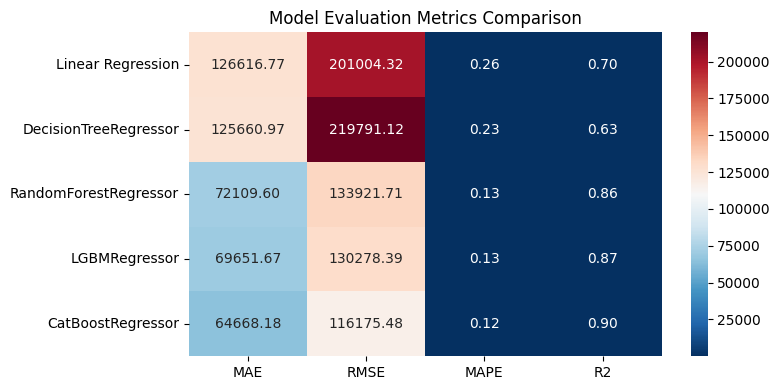

In [13]:
# Исходные метрики
initial_metrics = train_evaluate_models_cv(
    models=models, X=X, y=y, preprocessor=None, cv=cv, seed=SEED, classification=False
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование признаков
В нашем датасете имеются признаки **sqft_living, sqft_lot, sqft_above, sqft_living15, sqft_lot15**, которые имеют асимметричное распределение. Логарифмирование позволит сделать их более нормальными

#### 2.1.1 Без удаления столбцов

In [21]:
X_log = X.copy()

In [22]:
X_log["sqft_living_log"] = np.log1p(X_log["sqft_living"])
X_log["sqft_lot_log"] = np.log1p(X_log["sqft_lot"])
X_log["sqft_above_log"] = np.log1p(X_log["sqft_above"])
X_log["sqft_living15_log"] = np.log1p(X_log["sqft_living15"])
X_log["sqft_lot15_log"] = np.log1p(X_log["sqft_lot15"])


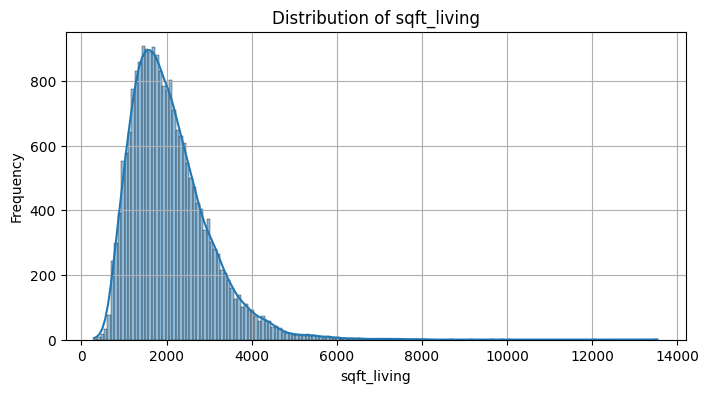

In [23]:
plot_hist_numeric(X_log, "sqft_living")

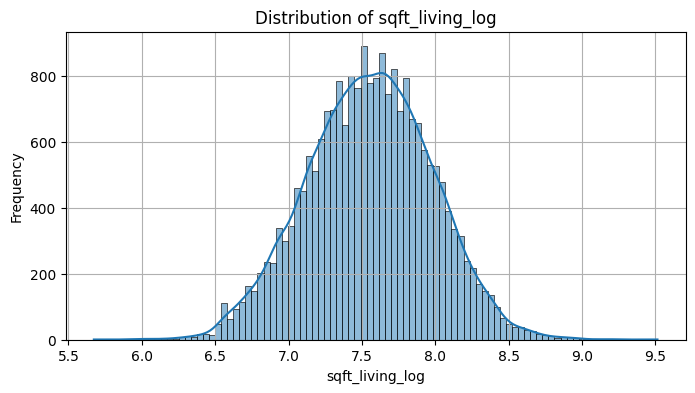

In [24]:
plot_hist_numeric(X_log, "sqft_living_log")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 25
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3550
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 27
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3617
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 27
[LightGBM] [Info] S

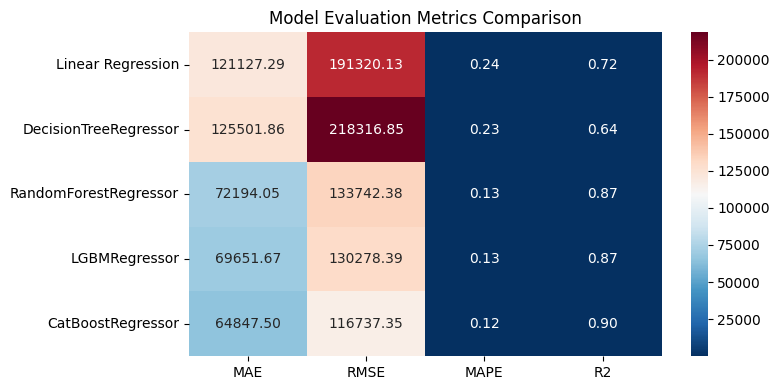

In [25]:
log_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      4.335509  4.817899  5.707609  4.071462
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor -0.117118  0.133909 -0.162693  0.043264
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.277291 -0.483639 -0.228778 -0.107364)

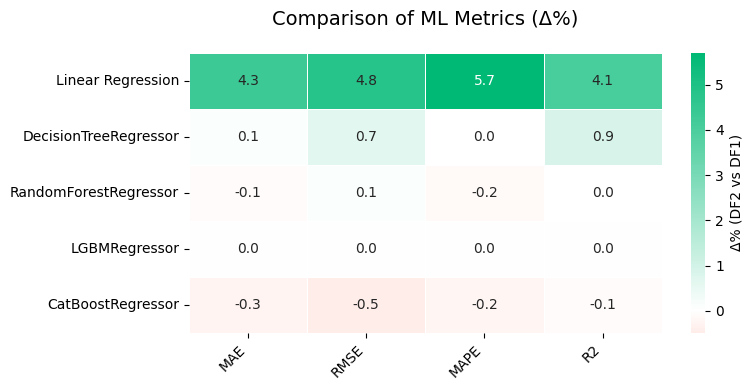

In [28]:
# сравним изначальные метрики с метриками после логарифмирования
compare_metrics_heatmap(initial_metrics, log_metrics)

Улучшение метрик только у линейной регрессии

#### 2.1.2 С удалением исходных столбцов

In [40]:
X_log_delete = X.copy()

In [41]:
X_log_delete["sqft_living"] = np.log1p(X_log_delete["sqft_living"])
X_log_delete["sqft_lot"] = np.log1p(X_log_delete["sqft_lot"])
X_log_delete["sqft_above"] = np.log1p(X_log_delete["sqft_above"])
X_log_delete["sqft_living15"] = np.log1p(X_log_delete["sqft_living15"])
X_log_delete["sqft_lot15"] = np.log1p(X_log_delete["sqft_lot15"])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the t

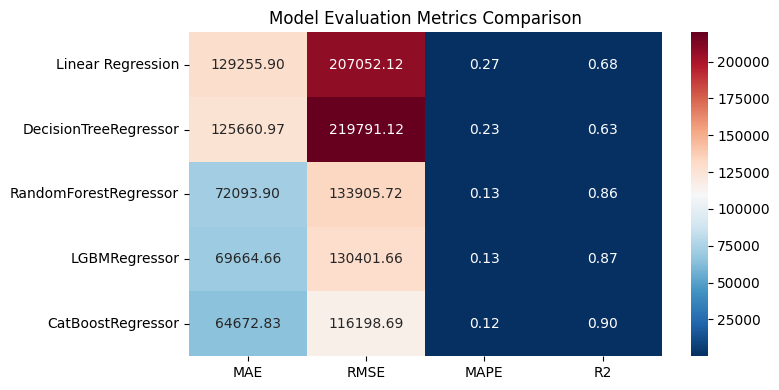

In [42]:
log_delete_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log_delete,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -2.084341 -3.008792 -3.356193 -2.659138
 DecisionTreeRegressor  0.000000  0.000000  0.000000  0.000000
 RandomForestRegressor  0.021770  0.011943 -0.058958  0.004333
 LGBMRegressor         -0.018648 -0.094624 -0.010875 -0.027361
 CatBoostRegressor     -0.007189 -0.019975  0.000097 -0.004513)

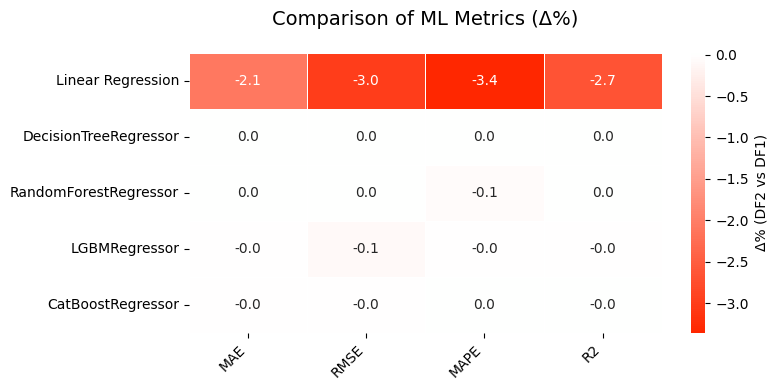

In [43]:
compare_metrics_heatmap(initial_metrics, log_delete_metrics)

Ухудшение метрик только у линейной регрессии

### 2.2 Логарифмическое преобразование таргета

In [44]:
y_log = y.copy()

In [46]:
y_log = np.log1p(y_log)

In [47]:
y_log

16768    12.988834
9596     13.579789
9587     13.422469
20602    13.226725
11577    12.994532
           ...    
7898     12.117247
928      12.791080
5637     13.017005
13053    13.006955
16594    14.085538
Name: price, Length: 21613, dtype: float64

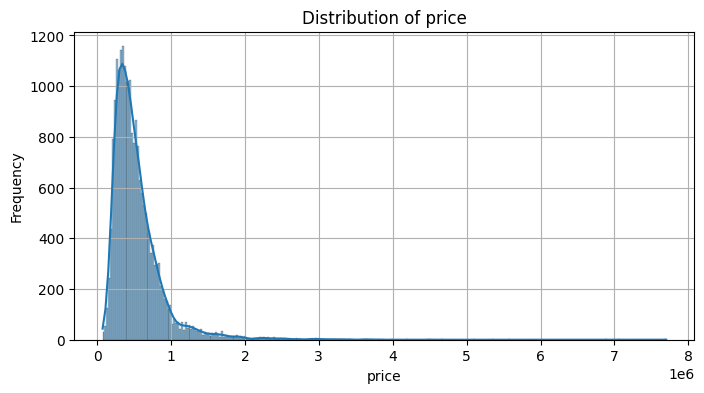

In [51]:
plot_hist_numeric(pd.DataFrame(y), "price")

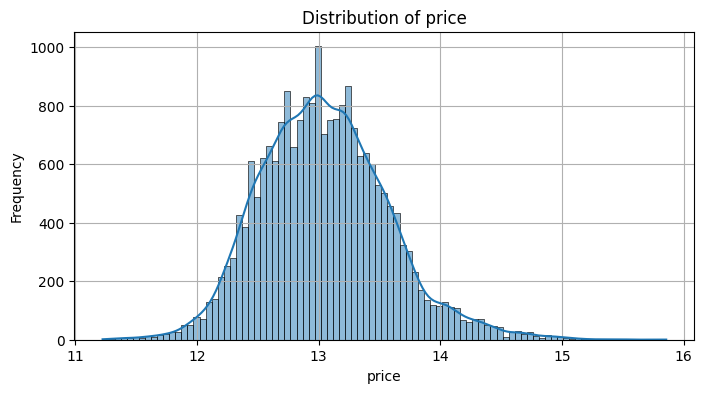

In [50]:
plot_hist_numeric(pd.DataFrame(y_log), "price")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 13.074815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 13.065441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] Start tra

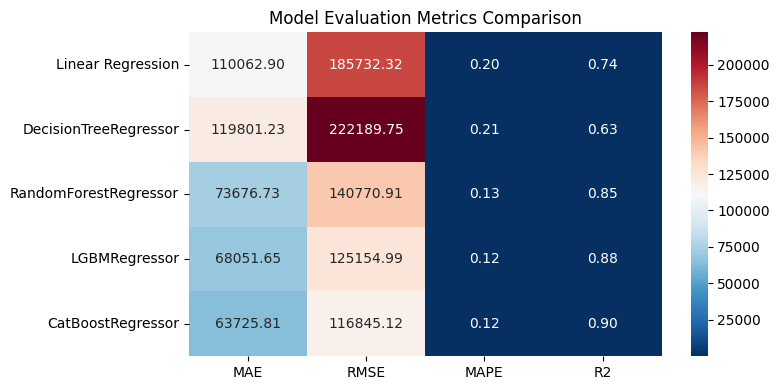

In [55]:
y_log_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y_log,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
    use_log_target=True,
)

(<Figure size 800x400 with 2 Axes>,
                              MAE      RMSE       MAPE        R2
 Linear Regression      13.074000  7.597843  22.677755  6.312090
 DecisionTreeRegressor   4.663139 -1.091322   7.908936 -0.946881
 RandomForestRegressor  -2.173262 -5.114330   1.377782 -1.644489
 LGBMRegressor           2.297176  3.932651   4.025217  1.156873
 CatBoostRegressor       1.457242 -0.576401   3.650859 -0.127665)

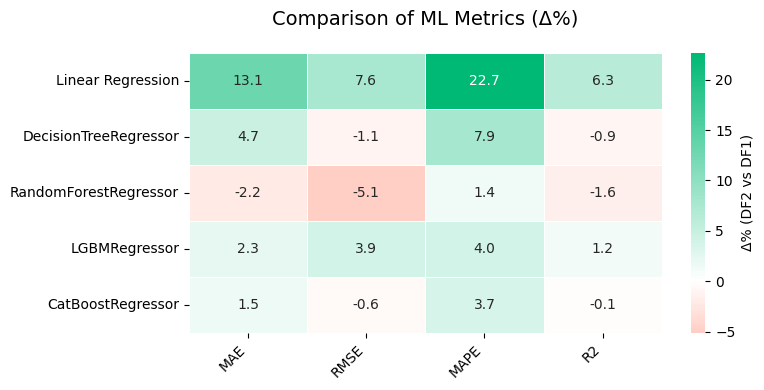

In [56]:
compare_metrics_heatmap(initial_metrics, y_log_metrics)

Большое улучшение у линейной регрессии.

У градиентных бустингов немного улучшился mape, r2 не изменился

### 2.3 Создание нового признака has_basement

In [57]:
X_has_basement = X.copy()

In [ ]:
X_has_basement["has_basement"] = (X_has_basement["sqft_basement"] > 0).astype(int)

In [67]:
X_has_basement["has_basement"].value_counts()

has_basement
0    13126
1     8487
Name: count, dtype: int64

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

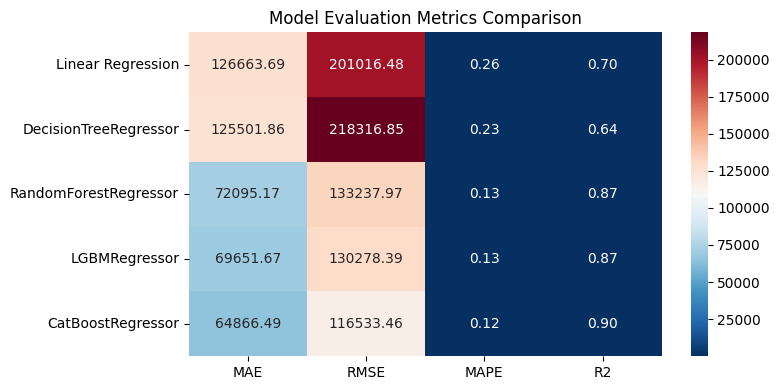

In [68]:
has_basement_metrics = train_evaluate_models_cv(
    models=models,
    X=X_has_basement,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.037058 -0.006051 -0.017687 -0.005193
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.020006  0.510551  0.037254  0.159957
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.306654 -0.308137 -0.450366 -0.065127)

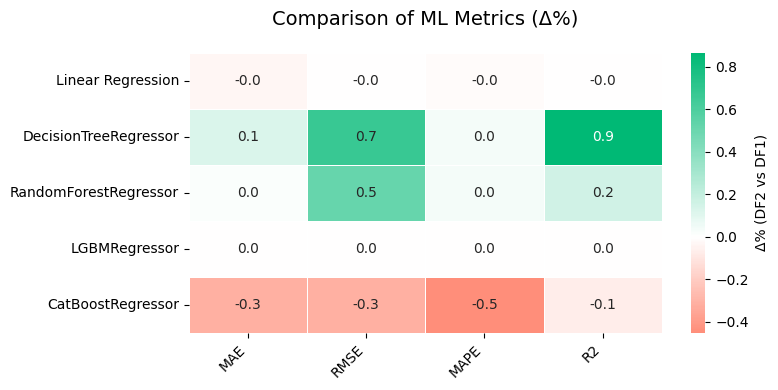

In [69]:
compare_metrics_heatmap(initial_metrics, has_basement_metrics)

Метрики практически не изменились

Небольшое улучшение у дерева и леса. У catboost небольшое ухудшение

### 2.4 Биннинг bedrooms

0, 1-2, 3-5, 6+.

#### 2.4.1 Без удаления

In [70]:
X_bedrooms_binning = X.copy()

In [71]:
bins = [-np.inf, 0, 2, 5, np.inf]
labels = [0, 1, 2, 3]


X_bedrooms_binning["bedrooms_bins"] = pd.cut(
    X_bedrooms_binning["bedrooms"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2236
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

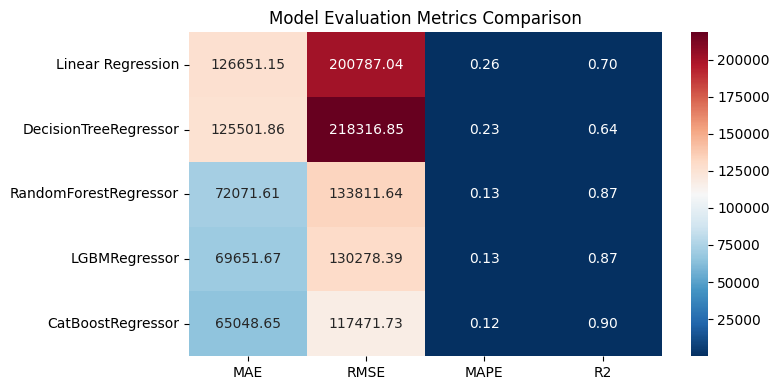

In [73]:
bedrooms_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=X_bedrooms_binning,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.027153  0.108093 -0.147424  0.094798
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.052680  0.082192  0.075846  0.029031
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.588344 -1.115767 -0.417032 -0.245620)

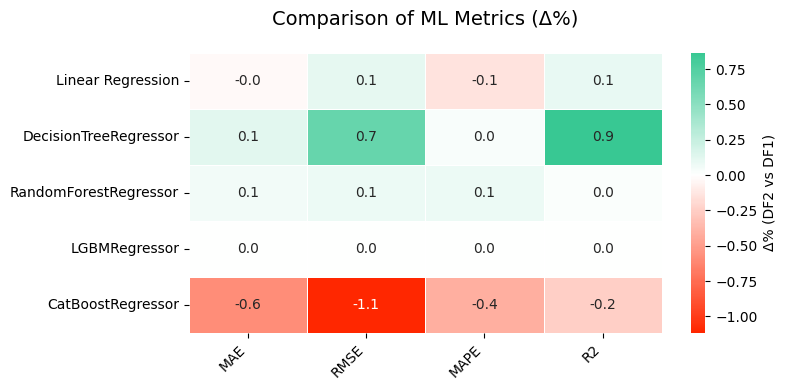

In [74]:
compare_metrics_heatmap(initial_metrics, bedrooms_binning_metrics)

Метрики практически не изменились

Небольшое улучшение у дерева. У catboost небольшое ухудшение

#### 2.4.2 С удалением

In [75]:
X_bedrooms_binning_del = X.copy()

In [76]:
bins = [-np.inf, 0, 2, 5, np.inf]
labels = [0, 1, 2, 3]


X_bedrooms_binning_del["bedrooms"] = pd.cut(
    X_bedrooms_binning_del["bedrooms"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the t

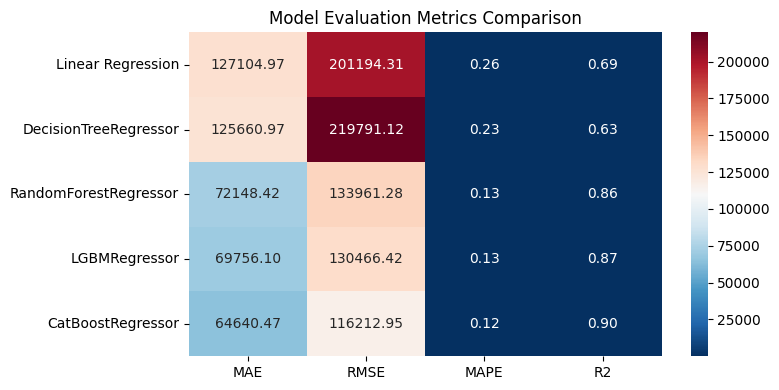

In [77]:
bedrooms_binning_del_metrics = train_evaluate_models_cv(
    models=models,
    X=X_bedrooms_binning_del,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.385570 -0.094521 -0.750226 -0.081946
 DecisionTreeRegressor  0.000000  0.000000  0.000000  0.000000
 RandomForestRegressor -0.053844 -0.029549  0.003210 -0.009819
 LGBMRegressor         -0.149923 -0.144333 -0.161417 -0.040517
 CatBoostRegressor      0.042856 -0.032249 -0.037939 -0.008986)

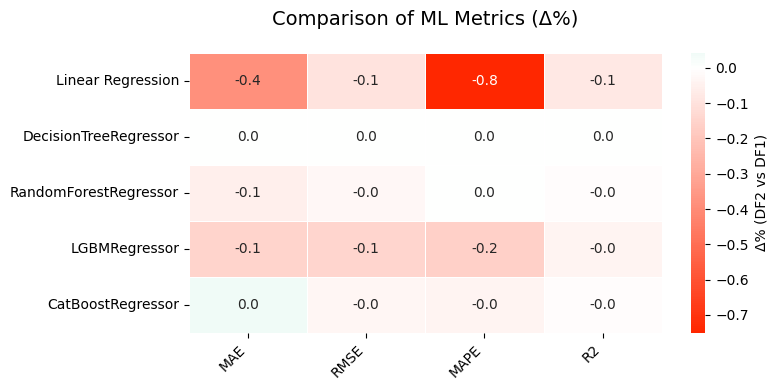

In [78]:
compare_metrics_heatmap(initial_metrics, bedrooms_binning_del_metrics)

Небольшое ухудшение метрик

### 2.5 Биннинг bathrooms

0, 0.5-1.75, 2-5, 6+.

#### 2.5.1 Без удаления

In [88]:
X_bathrooms_binning = X.copy()

In [89]:
bins = [-np.inf, 0, 1.75, 5, np.inf]
labels = [0, 1, 2, 3]


X_bathrooms_binning["bathrooms_bins"] = pd.cut(
    X_bathrooms_binning["bathrooms"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2236
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

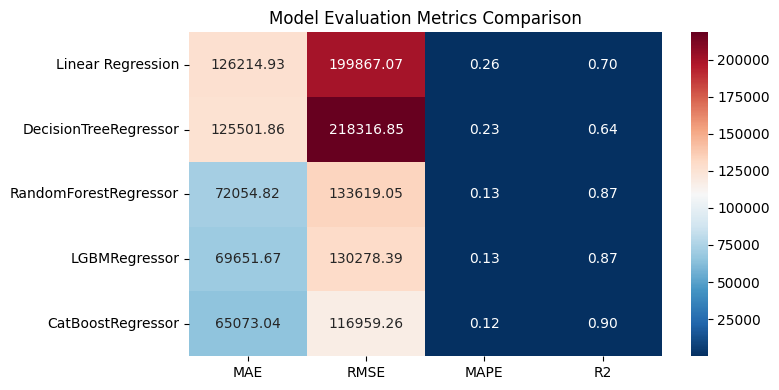

In [82]:
bathrooms_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=X_bathrooms_binning,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      0.317372  0.565780  0.292850  0.489087
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.075957  0.225996  0.022739  0.072527
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.626057 -0.674647 -0.504544 -0.142505)

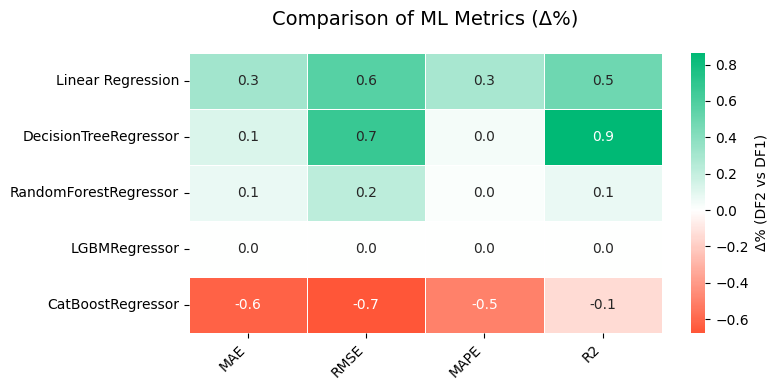

In [83]:
compare_metrics_heatmap(initial_metrics, bathrooms_binning_metrics)

Небольшое улучшение у линейной регресии и дерева.

Небольшое ухудшение у catboost

#### 2.5.2 С удалением

In [84]:
X_bathrooms_binning_del = X.copy()

In [85]:
bins = [-np.inf, 0, 1.75, 5, np.inf]
labels = [0, 1, 2, 3]


X_bathrooms_binning_del["bathrooms"] = pd.cut(
    X_bathrooms_binning_del["bathrooms"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2215
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2255
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

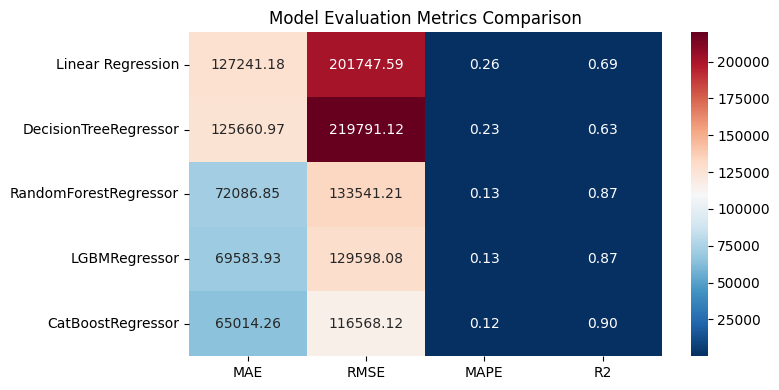

In [86]:
bathrooms_binning_del_metrics = train_evaluate_models_cv(
    models=models,
    X=X_bathrooms_binning_del,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.493149 -0.369779 -0.434888 -0.325358
 DecisionTreeRegressor  0.000000  0.000000  0.000000  0.000000
 RandomForestRegressor  0.031549  0.284119 -0.026226  0.089272
 LGBMRegressor          0.097269  0.522199 -0.062757  0.154670
 CatBoostRegressor     -0.535163 -0.337970 -0.448447 -0.065951)

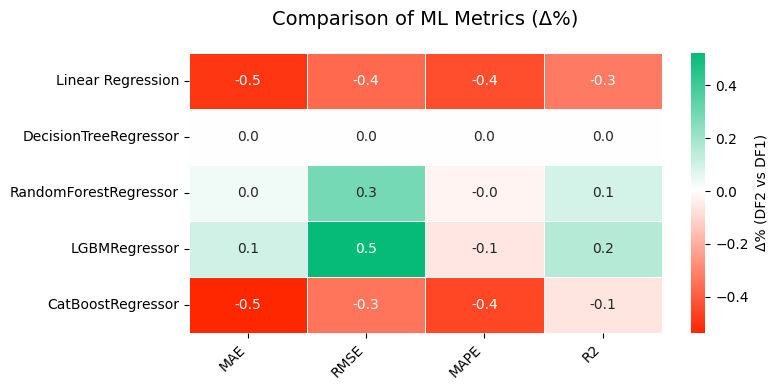

In [87]:
compare_metrics_heatmap(initial_metrics, bathrooms_binning_del_metrics)

Небольшое ухудшение метрик

### 2.6 Биннинг floors

1-1.5, 2-2.5, 3+.

#### 2.6.1 Без удаления

In [90]:
X_floors_binning = X.copy()

In [91]:
bins = [-np.inf, 1.5, 2.5, np.inf]
labels = [0, 1, 2]


X_floors_binning["floors_bins"] = pd.cut(
    X_floors_binning["floors"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

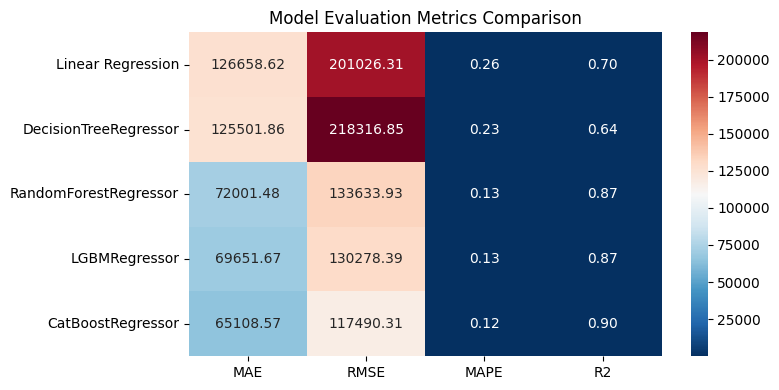

In [92]:
floors_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=X_floors_binning,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.033048 -0.010944 -0.054379 -0.009559
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.149932  0.214885  0.084434  0.069457
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.680994 -1.131760 -0.411460 -0.248122)

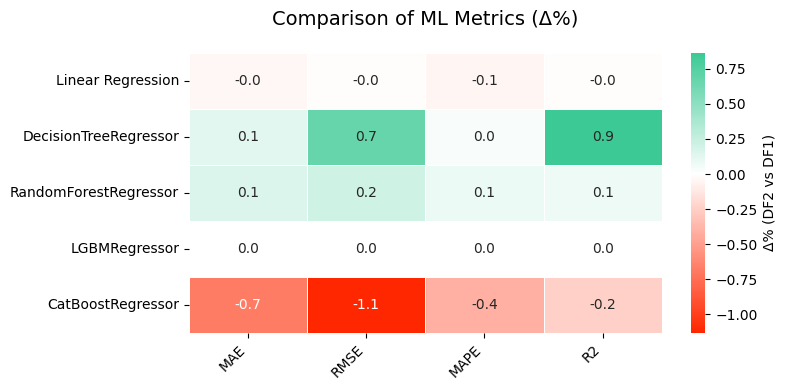

In [93]:
compare_metrics_heatmap(initial_metrics, floors_binning_metrics)

Небольшое улучшение у дерева.

Небольшое ухудшение у catboost

#### 2.6.2 С удалением

In [94]:
X_floors_binning_del = X.copy()

In [95]:
bins = [-np.inf, 1.5, 2.5, np.inf]
labels = [0, 1, 2]


X_floors_binning_del["floors"] = pd.cut(
    X_floors_binning_del["floors"], bins=bins, labels=labels
).astype(int)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2228
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] S

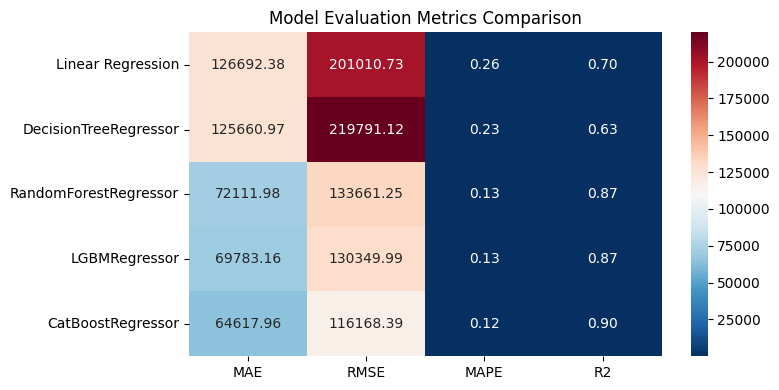

In [96]:
floors_binning_del_metrics = train_evaluate_models_cv(
    models=models,
    X=X_floors_binning_del,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.059715 -0.003191 -0.062029 -0.003108
 DecisionTreeRegressor  0.000000  0.000000  0.000000  0.000000
 RandomForestRegressor -0.003300  0.194484 -0.066202  0.063848
 LGBMRegressor         -0.188769 -0.054963 -0.179155 -0.022832
 CatBoostRegressor      0.077665  0.006109  0.102371  0.002024)

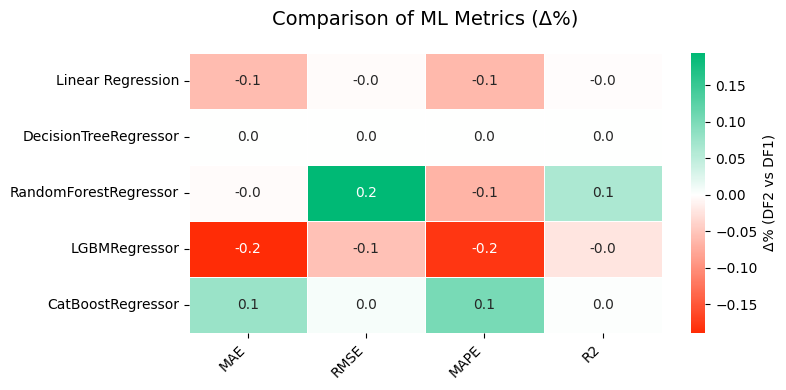

In [97]:
compare_metrics_heatmap(initial_metrics, floors_binning_del_metrics)

Метрики практически не изменились

### 2.7 Создание нового признака was_renovated

In [98]:
X_was_renovated = X.copy()

In [99]:
X_was_renovated["was_renovated"] = (X_was_renovated["yr_renovated"] > 0).astype(int)

In [100]:
X_was_renovated["was_renovated"].value_counts()

was_renovated
0    20699
1      914
Name: count, dtype: int64

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the t

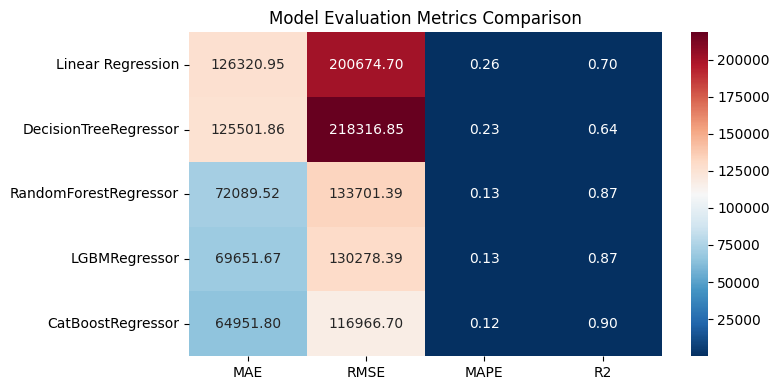

In [101]:
was_renovated_metrics = train_evaluate_models_cv(
    models=models,
    X=X_was_renovated,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      0.233632  0.163983  0.308460  0.143736
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.027836  0.164510 -0.002194  0.053736
 LGBMRegressor          0.000000  0.000000  0.000000  0.000000
 CatBoostRegressor     -0.438576 -0.681054 -0.349964 -0.153951)

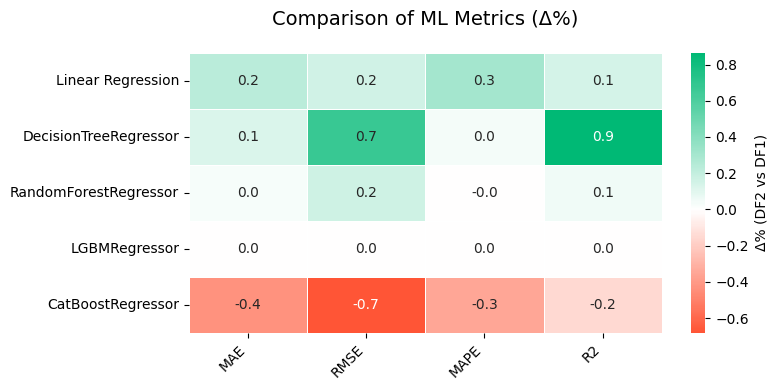

In [102]:
compare_metrics_heatmap(initial_metrics, was_renovated_metrics)

Небольшое улучшение у линейной регрессии и дерева


Небольшое ухудшение у catboost


### 2.8 Применение StandardScaler (стандартизация)

In [112]:
X_standard_scaler = X.copy()

In [113]:
preprocessor_standard_scaler = clone(preprocessor)
preprocessor_standard_scaler.transformers.append(
    (
        "scaler_numerical",
        StandardScaler(),
        NUMERICAL_FEATURES_LIST,
    )
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the t

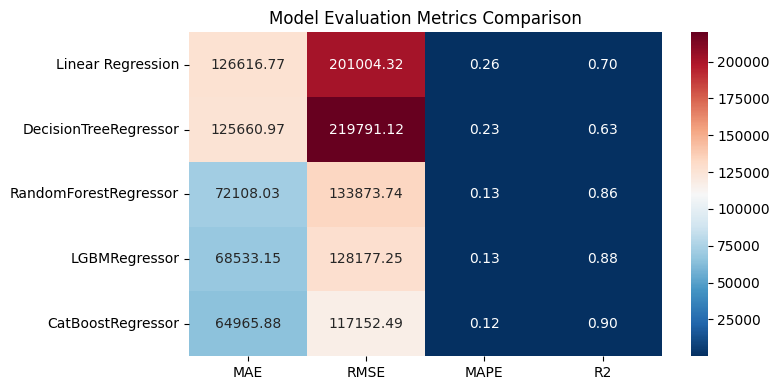

In [115]:
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE          MAPE            R2
 Linear Regression      5.620019e-12  8.977108e-13  7.343064e-12  8.300116e-13
 DecisionTreeRegressor  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 RandomForestRegressor  2.170170e-03  3.581780e-02 -2.571264e-02  1.073880e-02
 LGBMRegressor          1.605880e+00  1.612810e+00  8.278754e-01  4.666911e-01
 CatBoostRegressor     -4.603394e-01 -8.409776e-01 -3.505959e-01 -1.908803e-01)

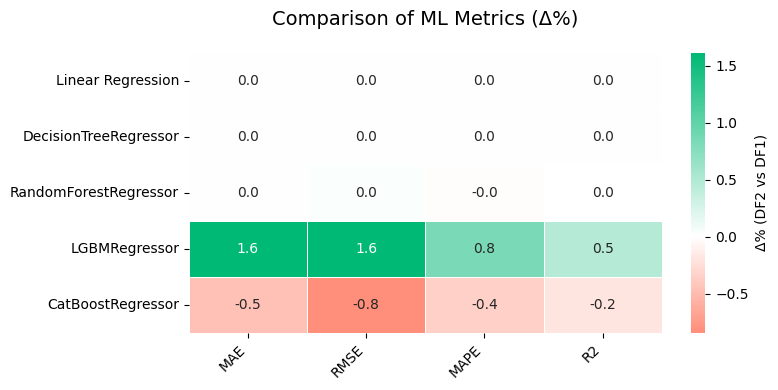

In [116]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

Небольшое улучшение у lgbm.

Небольшое ухудшение у catboost


### 2.9 Применение MinMaxScaler (нормализация)

In [128]:
X_normalized = X.copy()

In [129]:
preprocessor_normalize_scaler = clone(preprocessor)
preprocessor_normalize_scaler.transformers.append(
    (
        "normalizer_numerical",
        MinMaxScaler(),
        NUMERICAL_FEATURES_LIST,
    )
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] S

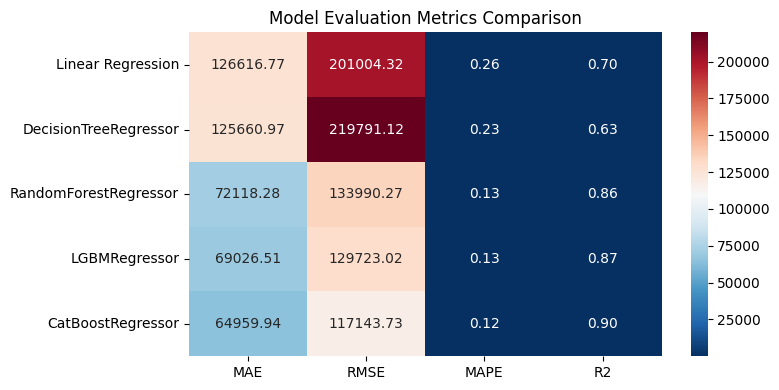

In [136]:
normalized_metrics = train_evaluate_models_cv(
    models=models,
    X=X_normalized,
    y=y,
    preprocessor=preprocessor_normalize_scaler,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE          MAPE            R2
 Linear Regression      5.470611e-12  9.121900e-13  7.086163e-12  8.300116e-13
 DecisionTreeRegressor  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 RandomForestRegressor -1.204416e-02 -5.119676e-02 -9.522874e-03 -1.578635e-02
 LGBMRegressor          8.975533e-01  4.262972e-01  4.212980e-01  1.146033e-01
 CatBoostRegressor     -4.511593e-01 -8.334318e-01 -3.488239e-01 -1.891283e-01)

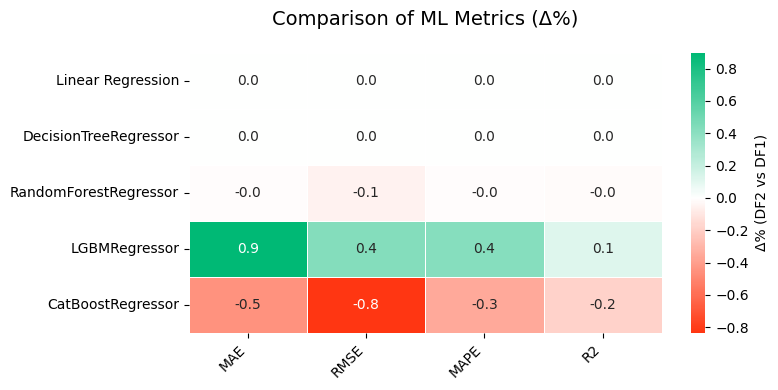

In [131]:
compare_metrics_heatmap(initial_metrics, normalized_metrics)

Небольшое улучшение у lgbm.

Небольшое ухудшение у catboost

### 2.10 Применение RobustScaler

In [133]:
X_robust_scaler = X.copy()

In [134]:
preprocessor_robust_scaler = clone(preprocessor)
preprocessor_robust_scaler.transformers.append(
    (
        "robust_scaler_numerical",
        RobustScaler(),
        NUMERICAL_FEATURES_LIST,
    )
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] S

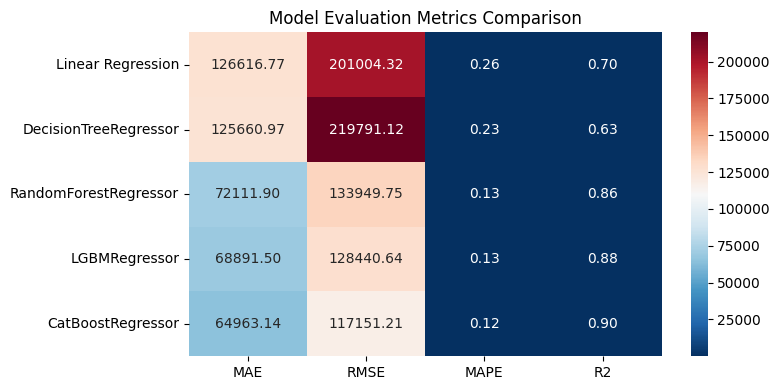

In [137]:
robust_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_robust_scaler,
    y=y,
    preprocessor=preprocessor_robust_scaler,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE          MAPE            R2
 Linear Regression      5.585540e-12  8.687524e-13  7.343064e-12  7.980881e-13
 DecisionTreeRegressor  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 RandomForestRegressor -3.197475e-03 -2.094111e-02 -1.289327e-02 -7.015178e-03
 LGBMRegressor          1.091395e+00  1.410629e+00  5.939543e-01  4.071780e-01
 CatBoostRegressor     -4.561149e-01 -8.398708e-01 -3.481304e-01 -1.906358e-01)

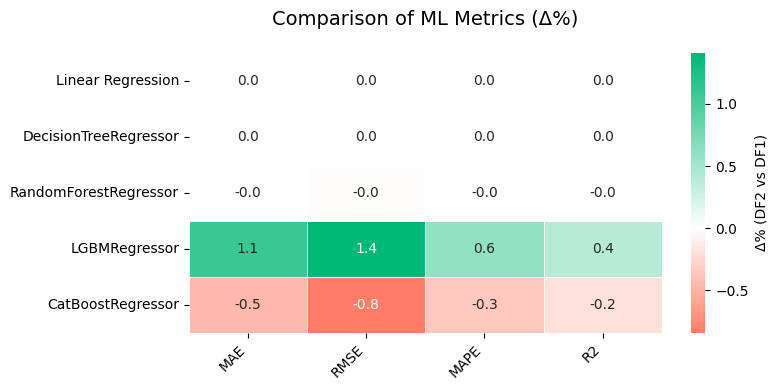

In [139]:
compare_metrics_heatmap(initial_metrics, robust_scaler_metrics)

Небольшое улучшение у lgbm.

Небольшое ухудшение у catboost

### 2.11 Применение CatBoostEncoder для категориальных переменных

In [143]:
X_catboost_encoding = X.copy()

In [144]:
preprocessor_catboost_encoding = clone(preprocessor)
preprocessor_catboost_encoding.transformers.append(
    (
        "catboost_categorical",
        CatBoostEncoder(
            cols=CATEGORICAL_FEATURES_LIST,
            sigma=None,
            a=1.0,
            handle_unknown="value",
            handle_missing="value",
            random_state=42,
        ),
        CATEGORICAL_FEATURES_LIST,
    )
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4238
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 22
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4274
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4338
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] S

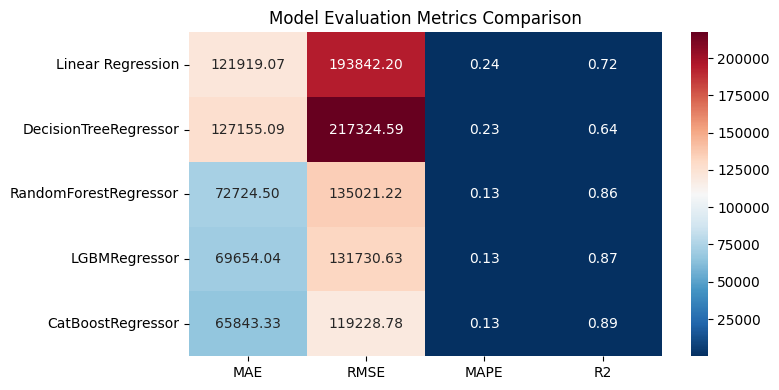

In [145]:
catboost_encoding_metrics = train_evaluate_models_cv(
    models=models,
    X=X_catboost_encoding,
    y=y,
    preprocessor=preprocessor_catboost_encoding,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      3.710172  3.563166  7.197310  3.009011
 DecisionTreeRegressor -1.189006  1.122216 -1.500865  1.308519
 RandomForestRegressor -0.852735 -0.821009 -1.382169 -0.292828
 LGBMRegressor         -0.003396 -1.114719 -0.155432 -0.366699
 CatBoostRegressor     -1.817203 -2.628175 -2.236490 -0.601752)

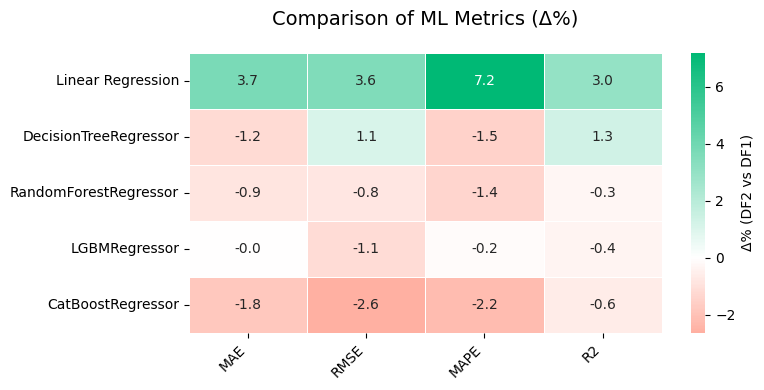

In [146]:
compare_metrics_heatmap(initial_metrics, catboost_encoding_metrics)

Улучшение только у линейной регрессии, у остальных моделей ухудшение

### 2.12 Обработка выбросов

#### 2.12.1 Winsorize

In [158]:
X_no_outliers = X.copy()

In [159]:
X_no_outliers = winsorize_outliers(X_no_outliers, "bedrooms", upper_bound=7)
X_no_outliers = winsorize_outliers(X_no_outliers, "bathrooms", upper_bound=5)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_living", upper_bound=6000)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_lot", upper_bound=25000)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_above", upper_bound=5000)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_basement", upper_bound=1500)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_living15", upper_bound=4500)
X_no_outliers = winsorize_outliers(X_no_outliers, "sqft_lot15", upper_bound=50000)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] S

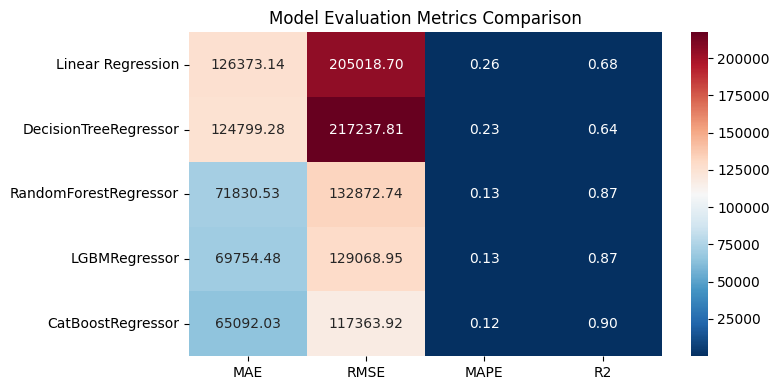

In [163]:
no_outliers_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_outliers,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      0.192413 -1.997163  0.143901 -1.740630
 DecisionTreeRegressor  0.685725  1.161701  0.353284  1.523417
 RandomForestRegressor  0.387008  0.783271 -0.181802  0.248303
 LGBMRegressor         -0.147593  0.928350 -0.279873  0.289397
 CatBoostRegressor     -0.655413 -1.022970 -0.809670 -0.235015)

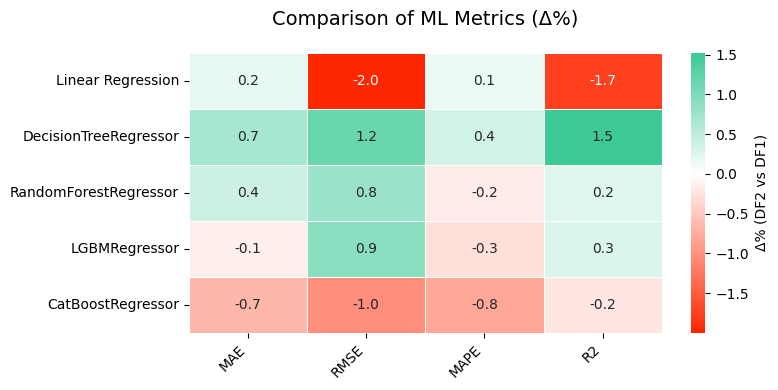

In [164]:
compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Небольшое улучшение у дерева

### 2.13 Использование IsolationForest для создания признака iforest_score (чем меньше, тем более аномальные значения)

In [15]:
class IsolationForestFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1, random_state=SEED):
        self.contamination = contamination
        self.random_state = random_state

    def fit(self, X, y=None):
        self.model_ = IsolationForest(
            contamination=self.contamination, random_state=self.random_state
        )
        self.model_.fit(X)
        return self

    def transform(self, X):
        X = X.copy()

        # score аномальности (чем меньше - тем более аномально)
        scores = self.model_.decision_function(X)

        X["iforest_score"] = scores
        return X

In [16]:
pipeline_isolation_forest = Pipeline(
    [("iforest", IsolationForestFeatures(contamination=0.1, random_state=SEED))]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2597
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

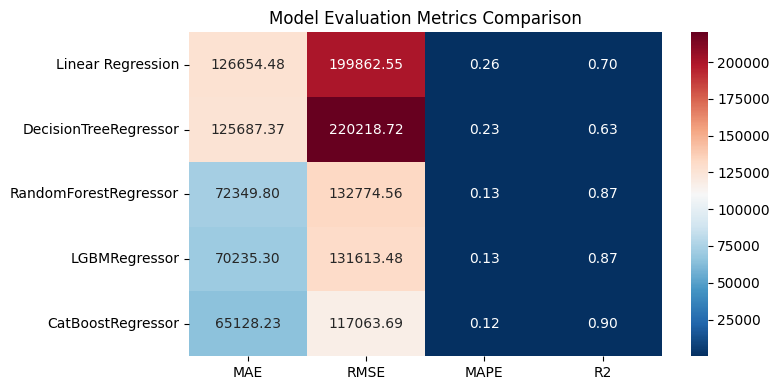

In [20]:
isolation_forest_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=pipeline_isolation_forest,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression     -0.029780  0.568033  0.939743  0.498350
 DecisionTreeRegressor -0.021008 -0.194545 -0.441658 -0.249009
 RandomForestRegressor -0.333107  0.856579 -1.294436  0.271787
 LGBMRegressor         -0.837921 -1.024797 -0.689427 -0.294342
 CatBoostRegressor     -0.711402 -0.764541 -0.833707 -0.165381)

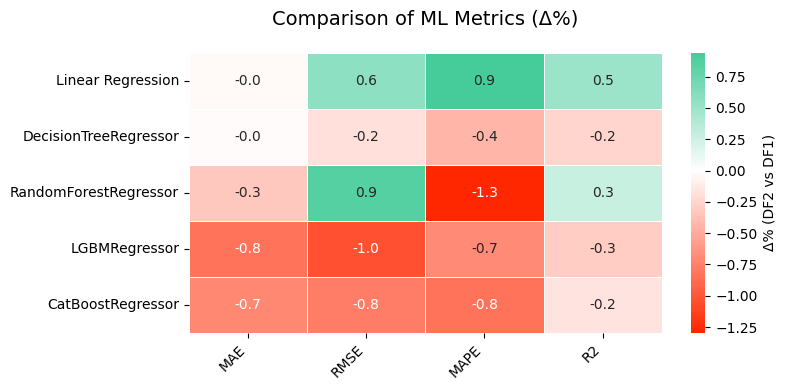

In [21]:
compare_metrics_heatmap(initial_metrics, isolation_forest_metrics)

Небольшие улучшения метрик у линейной регресии, у остальных моделей ухудшение

### 2.14 Создание нового признака sqft_per_room (средняя площадь на комнату)

In [177]:
X_sqft_per_room = X.copy()

In [178]:
X_sqft_per_room["sqft_per_room"] = X_sqft_per_room["sqft_living"] / (
    X_sqft_per_room["bedrooms"] + X_sqft_per_room["bathrooms"]
)

X_sqft_per_room["sqft_per_room"] = (
    X_sqft_per_room["sqft_per_room"].replace([np.inf, -np.inf], np.nan).fillna(0)
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2597
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

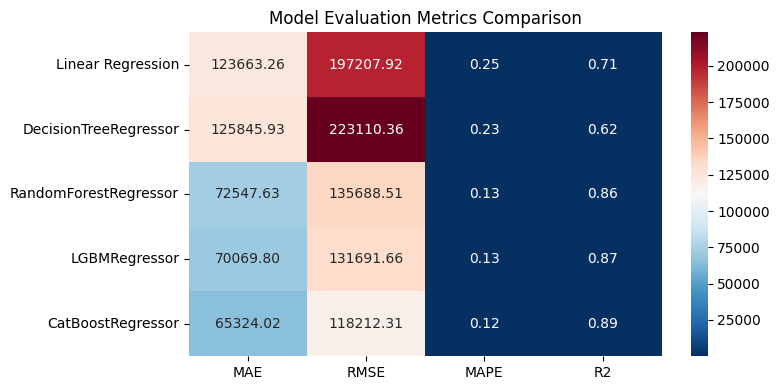

In [180]:
sqft_per_room_metrics = train_evaluate_models_cv(
    models=models,
    X=X_sqft_per_room,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      2.332642  1.888712  3.839984  1.623330
 DecisionTreeRegressor -0.147188 -1.510178 -0.073875 -1.781668
 RandomForestRegressor -0.607453 -1.319276 -0.428260 -0.411858
 LGBMRegressor         -0.600310 -1.084812 -0.416702 -0.333942
 CatBoostRegressor     -1.014157 -1.753229 -0.703405 -0.389856)

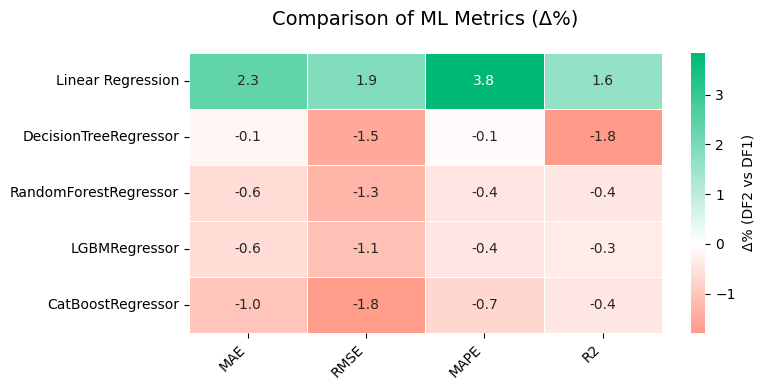

In [181]:
compare_metrics_heatmap(initial_metrics, sqft_per_room_metrics)

Улучшение только у линейной регрессии

### 2.15 Создание нового признака ratio_living_lot (доля жилой площади относительно участка)

In [182]:
X_ratio_living_lot = X.copy()

In [183]:
X_ratio_living_lot["ratio_living_lot"] = (
    X_ratio_living_lot["sqft_living"] / X_ratio_living_lot["sqft_lot"]
)

X_ratio_living_lot["ratio_living_lot"] = (
    X_ratio_living_lot["ratio_living_lot"].replace([np.inf, -np.inf], np.nan).fillna(0)
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2597
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

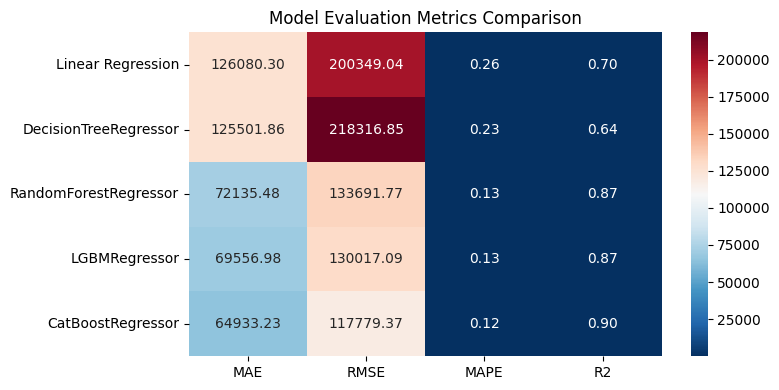

In [184]:
ratio_living_lot_metrics = train_evaluate_models_cv(
    models=models,
    X=X_ratio_living_lot,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      0.423700  0.326002  0.012848  0.287501
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor -0.035901  0.171694 -0.115160  0.051798
 LGBMRegressor          0.135953  0.200567  0.039677  0.051870
 CatBoostRegressor     -0.409860 -1.380574 -0.357432 -0.306596)

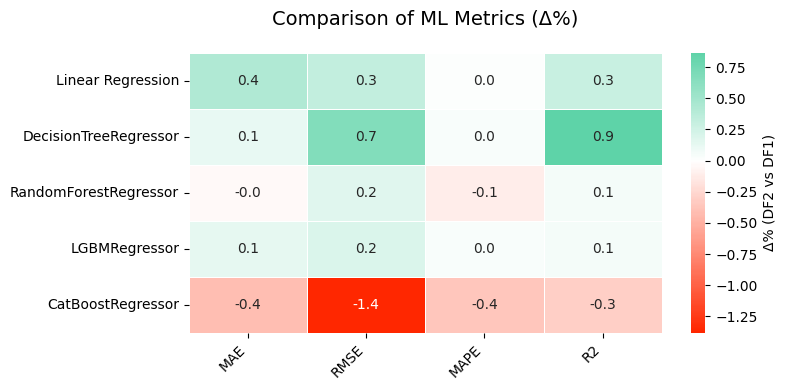

In [185]:
compare_metrics_heatmap(initial_metrics, ratio_living_lot_metrics)

Небольшое улучшение у дерева.

У catboost ухудшение

### 2.16 Создание нового признака house_age (возраст дома на момент продажи)

In [187]:
X_house_age = X.copy()

In [188]:
X_house_age["house_age"] = X_house_age["year"] - X_house_age["yr_built"]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 23
[LightGBM] [Info] S

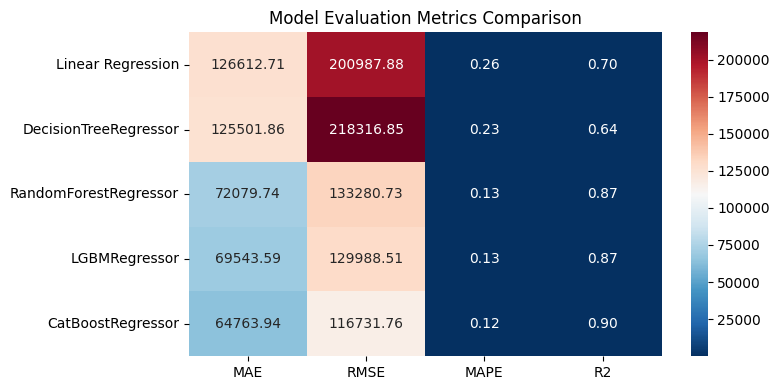

In [189]:
house_age_metrics = train_evaluate_models_cv(
    models=models,
    X=X_house_age,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE      MAPE        R2
 Linear Regression      0.003210  0.008176 -0.004325  0.007538
 DecisionTreeRegressor  0.126617  0.670760  0.035800  0.865017
 RandomForestRegressor  0.041399  0.478621  0.001603  0.150770
 LGBMRegressor          0.155179  0.222510  0.030593  0.062071
 CatBoostRegressor     -0.148076 -0.478827 -0.342938 -0.101671)

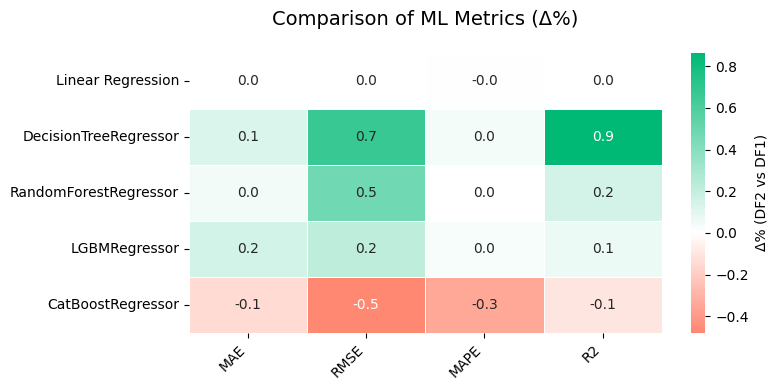

In [190]:
compare_metrics_heatmap(initial_metrics, house_age_metrics)

Небольшое улучшение у дерева и случайного леса.

У catboost ухудшение

### 2.17 Создание нового признака sqft_diff (отклонение площади дома от окрестных домов)

In [191]:
X_sqft_diff = X.copy()

In [193]:
X_sqft_diff["sqft_diff"] = X_sqft_diff["sqft_living15"] - X_sqft_diff["sqft_living"]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 21
[LightGBM] [Info] Start training from score 555520.569525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 23
[LightGBM] [Info] Start training from score 549558.387925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

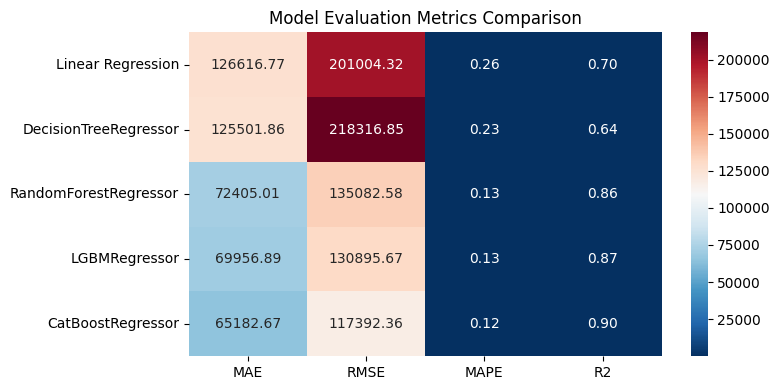

In [194]:
sqft_diff_metrics = train_evaluate_models_cv(
    models=models,
    X=X_sqft_diff,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE          MAPE            R2
 Linear Regression     -3.218007e-13 -4.734701e-12 -1.113234e-12 -4.118135e-12
 DecisionTreeRegressor  1.266170e-01  6.707600e-01  3.580012e-02  8.650174e-01
 RandomForestRegressor -4.096712e-01 -8.668311e-01 -3.376953e-01 -2.789948e-01
 LGBMRegressor         -4.382089e-01 -4.738166e-01 -2.667247e-01 -1.419829e-01
 CatBoostRegressor     -7.955861e-01 -1.047448e+00 -7.505374e-01 -2.273652e-01)

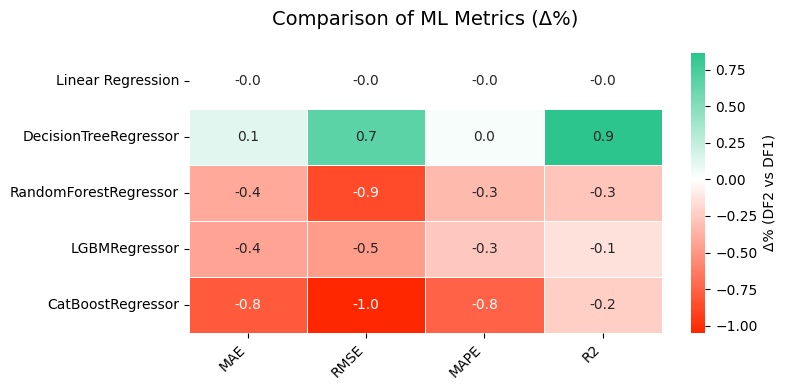

In [195]:
compare_metrics_heatmap(initial_metrics, sqft_diff_metrics)

Небольшое улучшение только у дерева.

У леса и бустингов ухудшение

## 3. Результаты

Из всех преобразований дали ощутимое улучшение метрик:
- Логарифмическое преобразование таргета

In [22]:
X_final = X.copy()
y_final = y.copy()

In [23]:
y_final = np.log1p(y_final)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 20
[LightGBM] [Info] Start training from score 13.074815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 7205, number of used features: 22
[LightGBM] [Info] Start training from score 13.065441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 10807, number of used features: 22
[LightGBM] [Info] Start tra

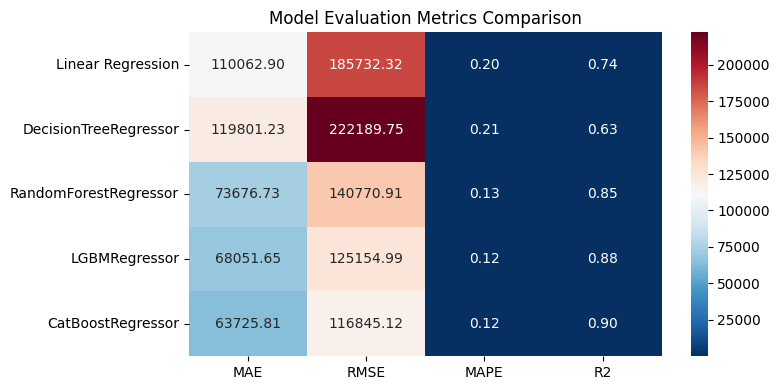

In [24]:
final_metrics = train_evaluate_models_cv(
    models=models,
    X=X_final,
    y=y_final,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
    use_log_target=True,
)

(<Figure size 800x400 with 2 Axes>,
                              MAE      RMSE       MAPE        R2
 Linear Regression      13.074000  7.597843  22.677755  6.312090
 DecisionTreeRegressor   4.663139 -1.091322   7.908936 -0.946881
 RandomForestRegressor  -2.173262 -5.114330   1.377782 -1.644489
 LGBMRegressor           2.297176  3.932651   4.025217  1.156873
 CatBoostRegressor       1.457242 -0.576401   3.650859 -0.127665)

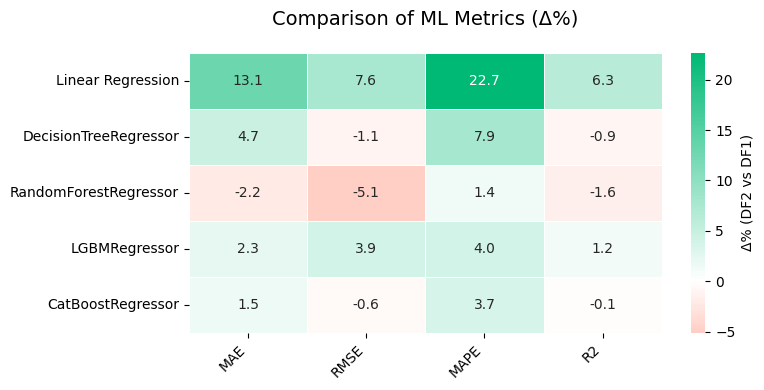

In [25]:
compare_metrics_heatmap(initial_metrics, final_metrics)

Лучше всего по метрикам показал себя catboost.

Он будет использован для дальнейшего подбора гиперпараметров